In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [188]:
df = pd.read_csv("Loan Prediction Train - refine.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,0,0.0,Graduate,0.0,5849,0,NaN,360.0,1.0,Urban,1
1,LP001003,Male,1,1.0,Graduate,0.0,4583,1508,128.0,360.0,1.0,Rural,0
2,LP001005,Male,1,0.0,Graduate,1.0,3000,0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,1,0.0,Not Graduate,0.0,2583,2358,120.0,360.0,1.0,Urban,1
4,LP001008,Male,0,0.0,Graduate,0.0,6000,0,141.0,360.0,1.0,Urban,1


### Let's still fill in Gender & Depdents with the mode for nulls since there's only 2%

In [189]:
mode_vars = ["Gender", "Dependents"]
mode_dict = {}
for var in mode_vars:
    frequencies = df[var].value_counts()
    val = np.argmax(frequencies)
    mode_dict[var] = val

df = df.replace(to_replace=np.nan,value=mode_dict)

### Also Fill in Loan Amount based on means from given data

In [190]:
print("Loan Amount isn't a simple categorical variable, and will likely have an important part in the model\n")
print("We'll fill it in with the average based on education,gender,married,dependents, and self-employed\n")

total_mean = round(df["LoanAmount"].mean())
temp_list = []
for i in range(0,len(df)):
    if np.isnan(df.iloc[i]["LoanAmount"]):
        married = df.iloc[i]["Married"]
        temp = df[df["Married"]==married]
        gender = df.iloc[i]["Gender"]
        temp = temp[temp["Gender"]==gender]
        dependents = df.iloc[i]["Dependents"]
        temp = temp[temp["Dependents"]==dependents]
        education = df.iloc[i]["Education"]
        temp = temp[temp["Education"]==education]
        self = df.iloc[i]["Self_Employed"]
        temp = temp[temp["Self_Employed"]==self]
        if temp.empty or len(temp) == 1:
            df.at[i,"LoanAmount"] = total_mean
        elif len(temp) > 1:
            df.at[i,"LoanAmount"] = round(temp["LoanAmount"].mean(),0)
null_entries = len(df[df["LoanAmount"].isnull()])

Loan Amount isn't a simple categorical variable, and will likely have an important part in the model

We'll fill it in with the average based on education,gender,married,dependents, and self-employed



### New Features

In [191]:
df["Combined_Income"] = df["ApplicantIncome"] + df["CoapplicantIncome"]
df["Income_Percent"] = df["Combined_Income"]/df["LoanAmount"]
df["Family"] = float(0)
df["Cosigned"] = float(0)

temp = df[df["Married"]==1][df["Dependents"] >=1]
f_ndx = df.columns.values.tolist().index("Family")
for i in range(0,len(df)):
    if i in temp.index.tolist():
        df.iat[i,f_ndx] = float(1)
        
temp = df[df["CoapplicantIncome"]>0]
c_ndx = df.columns.values.tolist().index("Cosigned")
for i in range(0,len(df)):
    if i in temp.index.tolist():
        df.iat[i,c_ndx] = float(1)

C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


{0.0, 100.0, 200.0, 300.0, 400.0}
{0.0: 0.6086956521739131, 100.0: 0.6808510638297872, 200.0: 0.75, 300.0: 0.699047619047619, 400.0: 0.4}



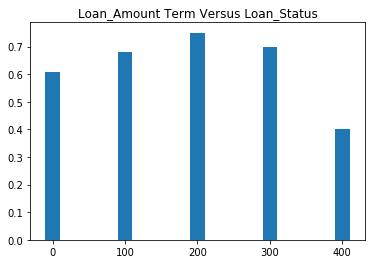

Based on this we can see that Loan Amount should really be better treated as a categorical variable


In [192]:
l_ndx = df.columns.values.tolist().index("Loan_Amount_Term")
for i in range(len(df)):
    cur = df.iloc[i]["Loan_Amount_Term"] 
    if cur >= 400:
        df.iat[i,l_ndx] = 400
    elif cur >= 300:
        df.iat[i,l_ndx] = 300
    elif cur >= 200:
        df.iat[i,l_ndx] = 200
    elif cur >= 100:
        df.iat[i,l_ndx] = 100
    else:
        df.iat[i,l_ndx] = 0

print(set(df["Loan_Amount_Term"].values))
temp = {}
for length in list(set(plot_df["Loan_Amount_Term"].values)):
    arr = df[df["Loan_Amount_Term"] == length]
    temp[length] = (len(arr[arr["Loan_Status"] == 1])/len(arr))

print(temp)
print()
x = list(range(0,len(temp.keys())))
plt.bar(list(temp.keys()),list(temp.values()),width=20)
plt.title("Loan_Amount Term Versus Loan_Status")
plt.show()

print("Based on this we can see that Loan Amount should really be better treated as a categorical variable")

[0.0, 1.0]
{0.0: 0.6758793969849246, 1.0: 0.7083333333333334}



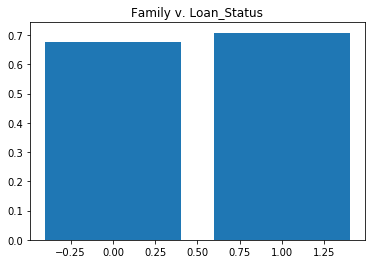

Based on this we can see that having a family gives a slight benefit as expected


In [193]:
plot_df = df

temp = {}
print(list(set(plot_df["Family"].values)))
for f in list(set(plot_df["Family"].values)):
    arr = df[df["Family"] == f]
    temp[f] = (len(arr[arr["Loan_Status"] == 1])/len(arr))

print(temp)
print()
x = list(range(0,len(temp.keys())))
plt.bar(list(temp.keys()),list(temp.values()))
plt.title("Family v. Loan_Status")
plt.show()

print("Based on this we can see that having a family gives a slight benefit as expected")

{0.0: 0.6483516483516484, 1.0: 0.718475073313783}



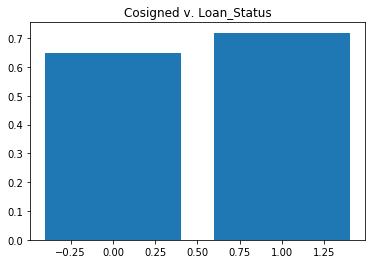

Based on this we can see that Cosigning a loan gives a slight benefit as expected


In [194]:
plot_df = df

temp = {}
for c in list(set(plot_df["Cosigned"].values)):
    arr = df[df["Cosigned"] == c]
    temp[c] = (len(arr[arr["Loan_Status"] == 1])/len(arr))

print(temp)
print()
x = list(range(0,len(temp.keys())))
plt.bar(list(temp.keys()),list(temp.values()))
plt.title("Cosigned v. Loan_Status")
plt.show()

print("Based on this we can see that Cosigning a loan gives a slight benefit as expected")

### Treat all nulls as a separate category

In [195]:
cat_list = df.select_dtypes(include=[object]).columns.values.tolist()
cat_list = cat_list + ["Married","Dependents","Self_Employed","Credit_History","Property_Area","Loan_Amount_Term"]
cat_list.remove("Loan_ID")
df = pd.get_dummies(df,columns=cat_list,dummy_na=True)

In [196]:
print(df.columns.values)
df.head()

['Loan_ID' 'ApplicantIncome' 'CoapplicantIncome' 'LoanAmount' 'Loan_Status'
 'Combined_Income' 'Income_Percent' 'Family' 'Cosigned' 'Gender_Female'
 'Gender_Male' 'Gender_nan' 'Education_Graduate' 'Education_Not Graduate'
 'Education_nan' 'Property_Area_Rural' 'Property_Area_Semiurban'
 'Property_Area_Urban' 'Property_Area_nan' 'Married_0.0' 'Married_1.0'
 'Married_nan' 'Dependents_0.0' 'Dependents_1.0' 'Dependents_2.0'
 'Dependents_3.0' 'Dependents_nan' 'Self_Employed_0.0' 'Self_Employed_1.0'
 'Self_Employed_nan' 'Credit_History_0.0' 'Credit_History_1.0'
 'Credit_History_nan' 'Property_Area_Rural' 'Property_Area_Semiurban'
 'Property_Area_Urban' 'Property_Area_nan' 'Loan_Amount_Term_0.0'
 'Loan_Amount_Term_100.0' 'Loan_Amount_Term_200.0' 'Loan_Amount_Term_300.0'
 'Loan_Amount_Term_400.0' 'Loan_Amount_Term_nan']


,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Status,Combined_Income,Income_Percent,Family,Cosigned,Gender_Female,...,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Property_Area_nan,Loan_Amount_Term_0.0,Loan_Amount_Term_100.0,Loan_Amount_Term_200.0,Loan_Amount_Term_300.0,Loan_Amount_Term_400.0,Loan_Amount_Term_nan
0,LP001002,5849,0,134.0,1,5849,43.649254,0.0,0.0,0,...,0,0,1,0,0,0,0,1,0,0
1,LP001003,4583,1508,128.0,0,6091,47.585938,1.0,1.0,0,...,1,0,0,0,0,0,0,1,0,0
2,LP001005,3000,0,66.0,1,3000,45.454545,0.0,0.0,0,...,0,0,1,0,0,0,0,1,0,0
3,LP001006,2583,2358,120.0,1,4941,41.175000,0.0,1.0,0,...,0,0,1,0,0,0,0,1,0,0
4,LP001008,6000,0,141.0,1,6000,42.553191,0.0,0.0,0,...,0,0,1,0,0,0,0,1,0,0


In [197]:
df.to_csv("Loan Prediction Train - final.csv")

### Now Repeat all updates on the Test File

In [198]:
df = pd.read_csv("Loan Prediction Test - refine.csv")
df.head()

mode_vars = ["Gender", "Dependents"]
mode_dict = {}
for var in mode_vars:
    frequencies = df[var].value_counts()
    val = np.argmax(frequencies)
    mode_dict[var] = val

df = df.replace(to_replace=np.nan,value=mode_dict)

total_mean = round(df["LoanAmount"].mean())
temp_list = []
l_ndx = df.columns.values.tolist().index("Loan_Amount_Term")
for i in range(0,len(df)):
    cur = df.iloc[i]["Loan_Amount_Term"]
    if np.isnan(df.iloc[i]["LoanAmount"]):
        married = df.iloc[i]["Married"]
        temp = df[df["Married"]==married]
        gender = df.iloc[i]["Gender"]
        temp = temp[temp["Gender"]==gender]
        dependents = df.iloc[i]["Dependents"]
        temp = temp[temp["Dependents"]==dependents]
        education = df.iloc[i]["Education"]
        temp = temp[temp["Education"]==education]
        self = df.iloc[i]["Self_Employed"]
        temp = temp[temp["Self_Employed"]==self]
        if temp.empty or len(temp) == 1:
            df.at[i,"LoanAmount"] = total_mean
        elif len(temp) > 1:
            df.at[i,"LoanAmount"] = round(temp["LoanAmount"].mean(),0)
    if cur >= 400:
        df.iat[i,l_ndx] = 400
    elif cur >= 300:
        df.iat[i,l_ndx] = 300
    elif cur >= 200:
        df.iat[i,l_ndx] = 200
    elif cur >= 100:
        df.iat[i,l_ndx] = 100
    else:
        df.iat[i,l_ndx] = 0

df["Combined_Income"] = df["ApplicantIncome"] + df["CoapplicantIncome"]
df["Income_Percent"] = df["Combined_Income"]/df["LoanAmount"]
df["Family"] = float(0)
df["Cosigned"] = float(0)

temp = df[df["Married"]==1][df["Dependents"] >=1]
f_ndx = df.columns.values.tolist().index("Family")
for i in range(0,len(df)):
    if i in temp.index.tolist():
        df.iat[i,f_ndx] = float(1)
        
temp = df[df["CoapplicantIncome"]>0]
c_ndx = df.columns.values.tolist().index("Cosigned")
for i in range(0,len(df)):
    if i in temp.index.tolist():
        df.iat[i,c_ndx] = float(1)

cat_list = df.select_dtypes(include=[object]).columns.values.tolist()
cat_list = cat_list + ["Married","Dependents","Self_Employed","Credit_History","Property_Area","Loan_Amount_Term"]
cat_list.remove("Loan_ID")

df = pd.get_dummies(df,columns=cat_list,dummy_na=True)

C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [199]:
df.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Combined_Income,Income_Percent,Family,Cosigned,Gender_Female,Gender_Male,...,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Property_Area_nan,Loan_Amount_Term_0.0,Loan_Amount_Term_100.0,Loan_Amount_Term_200.0,Loan_Amount_Term_300.0,Loan_Amount_Term_400.0,Loan_Amount_Term_nan
0,LP001015,5720,0,110.0,5720,52.000000,0.0,0.0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,LP001022,3076,1500,126.0,4576,36.317460,1.0,1.0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,LP001031,5000,1800,208.0,6800,32.692308,1.0,1.0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,LP001035,2340,2546,100.0,4886,48.860000,1.0,1.0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,LP001051,3276,0,78.0,3276,42.000000,0.0,0.0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [200]:
df.to_csv("Loan Prediction Test - final.csv")